# Imports

In [35]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import string
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
%matplotlib inline

# Dataset


**sentiment140 dataset**
- Contains 1,600,000 tweets extracted using the twitter api 
- The tweets have been annotated (0 = negative, 4 = positive) 
- Contains the following 6 fields:

**target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

**ids**: The id of the tweet ( 2087)

**date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

**flag**: The query (lyx). If there is no query, then this value is NO_QUERY.

**user**: the user that tweeted (robotickilldozr)

**text**: the text of the tweet (Lyx is cool)

In [5]:
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names= ["target", "ids", "date", "flag","user", "text"], error_bad_lines=False)
dataset.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5940\1094787425.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names= ["target", "ids", "date", "flag","user", "text"], error_bad_lines=False)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Preprocessing 

In [6]:
dataset = dataset.drop(['ids','date','flag','user'], axis=1)

In [7]:
dataset.tail()


,target,text
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,happy #charitytuesday @theNSPCC @SparksCharity...


In [8]:
dataset['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [9]:
dataset['target'] = dataset['target'].apply(lambda x: int(x))

In [10]:
dataset.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [11]:
dataset['cleanTweet'] = dataset.text.str.lower()
dataset[:20]

,target,text,cleanTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many times for the ball. man...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew,@kwesidei not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,@loltrish hey long time no see! yes.. rains a...
8,0,@Tatiana_K nope they didn't have it,@tatiana_k nope they didn't have it
9,0,@twittera que me muera ?,@twittera que me muera ?


In [12]:
x = dataset['text'][1]
type(x)
dataset = dataset.dropna()

In [13]:
#Remove users
dataset['cleanTweet'] = dataset['cleanTweet'].apply(lambda x: re.sub("@[\w]*", " ", x))

#Remove URLs
dataset['cleanTweet'] = dataset['cleanTweet'].apply(lambda x: re.sub("https?:\/\/\S+", " ", x))
dataset['cleanTweet'] = dataset['cleanTweet'].apply(lambda x: re.sub("www\.[a-z]?\.?(com)+|[a-z]+\.(com)", " ", x))

#Removing Special characters and numbers
dataset['cleanTweet'] = dataset['cleanTweet'].apply(lambda x: re.sub("[^a-zA-Z#']", " ", x))

In [14]:
dataset[:20]

,target,text,cleanTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got ...
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to ...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why a...
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains a bit on...
8,0,@Tatiana_K nope they didn't have it,nope they didn't have it
9,0,@twittera que me muera ?,que me muera


In [15]:
#TOKENIZATION
dataset['cleanTweet'] = dataset['cleanTweet'] .apply(lambda x: x.split())
dataset.head()

,target,text,cleanTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, that's, a, bummer, you, shoulda, got, d..."
1,0,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can't, update, his, face..."
2,0,@Kenichan I dived many times for the ball. Man...,"[i, dived, many, times, for, the, ball, manage..."
3,0,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"@nationwideclass no, it's not behaving at all....","[no, it's, not, behaving, at, all, i'm, mad, w..."


In [16]:
nltk.download("stopwords")
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
print(stopWords)

{'have', 'my', 'which', 'whom', 'here', 'because', "wouldn't", 'ours', 'doesn', 'below', 'such', 'few', "shouldn't", 'off', 'between', "shan't", "couldn't", 'him', 'so', 'how', 'no', 'with', 'hers', 'too', 'why', 'she', 'its', 'there', 'we', 'he', 'own', 'through', 'the', 'against', 'his', 'after', 'these', 'ourselves', 'hasn', 'further', 'can', 'our', 'll', 'did', 'y', 'herself', 'before', 'be', 'wasn', "it's", "mustn't", 'those', 'of', 'as', 'over', 'each', 'but', 'doing', 'that', "doesn't", 'should', 'most', 'your', 'during', 'than', 'myself', 's', 'needn', 'mustn', 'same', "should've", 'yourselves', 'aren', 'does', 'mightn', 'having', "you'll", 'or', 'weren', 'you', "you'd", 'couldn', 'while', "aren't", "needn't", 'is', 'in', 'more', 'from', 'are', 'where', "don't", 'once', 'd', 'ain', 'hadn', "wasn't", 'on', 'it', "you're", "didn't", "won't", 'being', "mightn't", 'shouldn', "haven't", 'above', 'until', 'for', "that'll", 'their', 'me', 'into', 'when', 'who', 'some', 'to', 'not', 'o

In [18]:
#Removing Stopwords
dataset['cleanTweet'] = dataset['cleanTweet'].apply(lambda x: ' '.join([word for word in x if word not in (stopWords)]))

In [19]:
dataset['cleanTweet'] = dataset['cleanTweet'] .apply(lambda x: x.split(' '))
dataset.head()

,target,text,cleanTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, that's, bummer, shoulda, got, david, ca..."
1,0,is upset that he can't update his Facebook by ...,"[upset, can't, update, facebook, texting, migh..."
2,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, times, ball, managed, save, rest..."
3,0,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....","[behaving, i'm, mad, can't, see]"


In [20]:
#Stemming
stemmer = PorterStemmer()
dataset['cleanTweet'] = dataset['cleanTweet'].apply(lambda x: [stemmer.stem(i) for i in x])
dataset.head()

,target,text,cleanTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, that', bummer, shoulda, got, david, car..."
1,0,is upset that he can't update his Facebook by ...,"[upset, can't, updat, facebook, text, might, c..."
2,0,@Kenichan I dived many times for the ball. Man...,"[dive, mani, time, ball, manag, save, rest, go..."
3,0,my whole body feels itchy and like its on fire,"[whole, bodi, feel, itchi, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....","[behav, i'm, mad, can't, see]"


In [21]:
dataset['cleanTweet'] = dataset['cleanTweet'].apply(lambda x: " ".join(x))
dataset.head()

,target,text,cleanTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that' bummer shoulda got david carr third...
1,0,is upset that he can't update his Facebook by ...,upset can't updat facebook text might cri resu...
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",behav i'm mad can't see


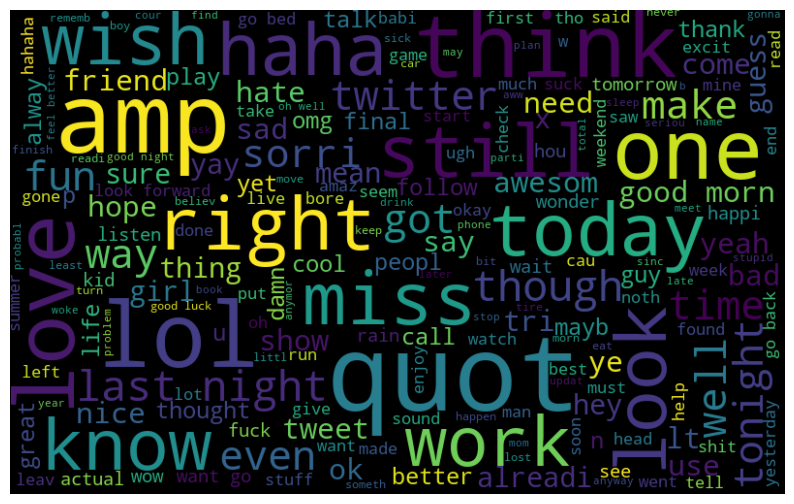

In [23]:
allWords = ' '.join([word for word in dataset['cleanTweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


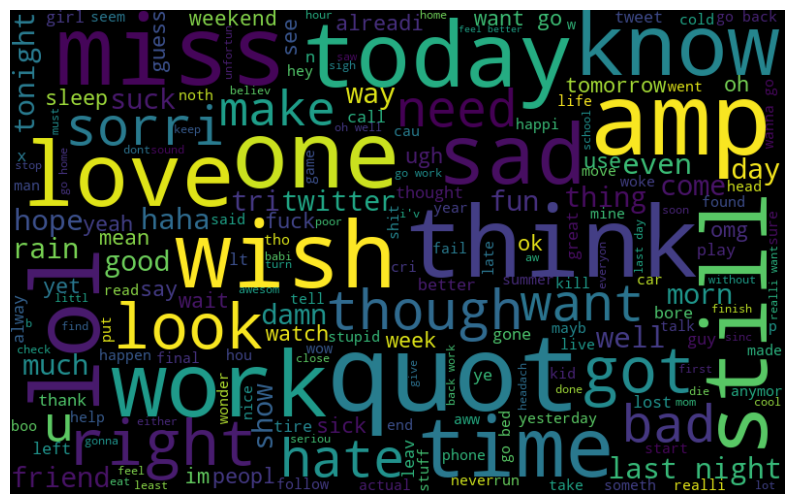

In [24]:
negativeWords =' '.join([text for text in dataset['cleanTweet'][dataset['target'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negativeWords)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

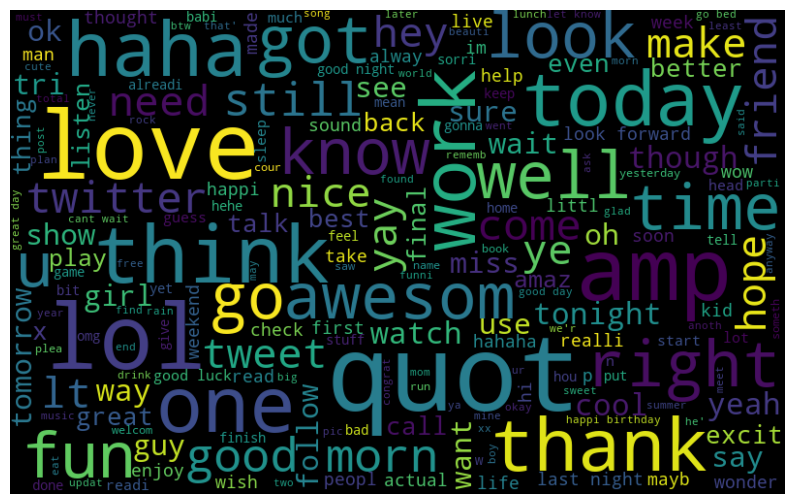

In [25]:
positiveWords =' '.join([text for text in dataset['cleanTweet'][dataset['target'] == 4]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positiveWords)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Training 

In [22]:
train_data, test_data = train_test_split(dataset, test_size=0.20,
                                         random_state=7)

In [23]:
encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())

y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


**Tokenizer**

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. The process is called Tokenization.

**tokenizer** create tokens for every word in the data corpus and map them to a index using dictionary.

**word_index** contains the index for each word

**vocab_size** represents the total number of word in the data **corpus**

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.cleanTweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 207618


Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH.

In [25]:
MAX_SEQUENCE_LENGTH = 30

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.cleanTweet),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)



Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. Here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. 

**Keras** offers an Embedding layer that can be used for neural networks on text data.

It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

It is a flexible layer that can be used in a variety of ways, such as:

It can be used alone to learn a word embedding that can be saved and used in another model later.
It can be used as part of a deep learning model where the embedding is learned along with the model itself.
It can be used to load a pre-trained word embedding model, a type of transfer learning.
The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

**input_dim**: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.

**output_dim**: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.

**input_length**: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [26]:
GLOVE_EMB = 'glove.6B.100d.txt'
EMBEDDING_DIM = 100

In [27]:
embeddings_index = {}

f = open(GLOVE_EMB,encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [29]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)


Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification

In [30]:
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [31]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           20761800  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 100)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            32064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

# Model Evaluation

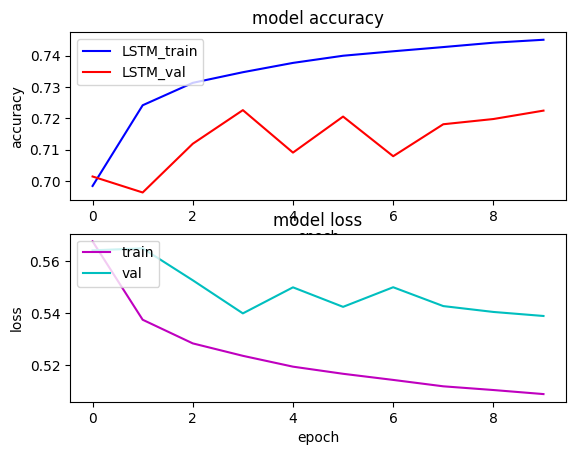

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')


In [33]:
def decode_sentiment(score):
    return 4 if score>0.5 else 0


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]


32/32 [==============================] - 26s 786ms/step


In [39]:
print(classification_report(list(test_data), y_pred_1d))

ValueError: Found input variables with inconsistent numbers of samples: [3, 320000]

In [37]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [38]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()


AttributeError: 'DataFrame' object has no attribute 'sentiment'